In [56]:
from datetime import datetime
from datetime import timedelta

import pandas
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

In [2]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release", "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["month"]
del df["day"]
del df["year"]
del df["post_month"]
df

,days_since_previous_release,release_post,date
id,,,
50,NaN,False,2016-02-15
123,NaN,False,2016-02-15
173,NaN,False,2016-02-15
156,NaN,False,2016-02-15
133,NaN,False,2016-02-15
...,...,...,...
275,7.0,True,2021-02-06
276,10.0,True,2021-02-16
277,7.0,True,2021-02-23


In [3]:
df.query("release_post == True & days_since_previous_release.isnull()")

,days_since_previous_release,release_post,date
id,,,


In [4]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [5]:
filled_in = [dict(df.iloc[0])]
# df should already be sorted by date
current_date = filled_in[0]["date"]
days_since_release = filled_in[0]["days_since_previous_release"] # should be 0
while current_date < df.iloc[-1]["date"]:
    days_since_release += 1
    current_date = current_date + timedelta(days=1)
    in_df = df[df["date"] == current_date]
    if len(in_df) == 1:
        filled_in.append({"date" : current_date, "release_post" : in_df.iloc[0]["release_post"],
                          "days_since_previous_release" : days_since_release})
        days_since_release = 0
    else:
        filled_in.append({"date" : current_date, "release_post" : False,
                          "days_since_previous_release" : days_since_release})
        
features_df = pandas.DataFrame(filled_in)
features_df

,days_since_previous_release,release_post,date
0,0.0,True,2017-02-17
1,1.0,False,2017-02-18
2,2.0,False,2017-02-19
3,3.0,False,2017-02-20
4,4.0,False,2017-02-21
...,...,...,...
1472,3.0,False,2021-02-28
1473,4.0,False,2021-03-01
1474,5.0,False,2021-03-02
1475,6.0,False,2021-03-03


In [6]:
features_df["release_post"].value_counts()

False    1288
True      189
Name: release_post, dtype: int64

In [7]:
features_df["weekday"] = features_df["date"].apply(lambda x : x.weekday())
features_df["month"] = features_df["date"].apply(lambda x : x.month)
features_df

,days_since_previous_release,release_post,date,weekday,month
0,0.0,True,2017-02-17,4,2
1,1.0,False,2017-02-18,5,2
2,2.0,False,2017-02-19,6,2
3,3.0,False,2017-02-20,0,2
4,4.0,False,2017-02-21,1,2
...,...,...,...,...,...
1472,3.0,False,2021-02-28,6,2
1473,4.0,False,2021-03-01,0,3
1474,5.0,False,2021-03-02,1,3
1475,6.0,False,2021-03-03,2,3


---

In [8]:
false_df = features_df[features_df["release_post"] == False].sample(
    n=len(features_df[features_df["release_post"] == True]), random_state=1024)
len(false_df)

189

In [14]:
all_df = false_df.append(features_df[features_df["release_post"] == True], ignore_index=True)

In [15]:
train_df = all_df.sample(n=int(len(all_df) * 0.80), random_state=1024).copy()
test_df = all_df[~all_df.index.isin(train_df.index)].copy()
print(len(train_df), len(test_df))

302 76


---

<AxesSubplot:xlabel='weekday', ylabel='days_since_previous_release'>

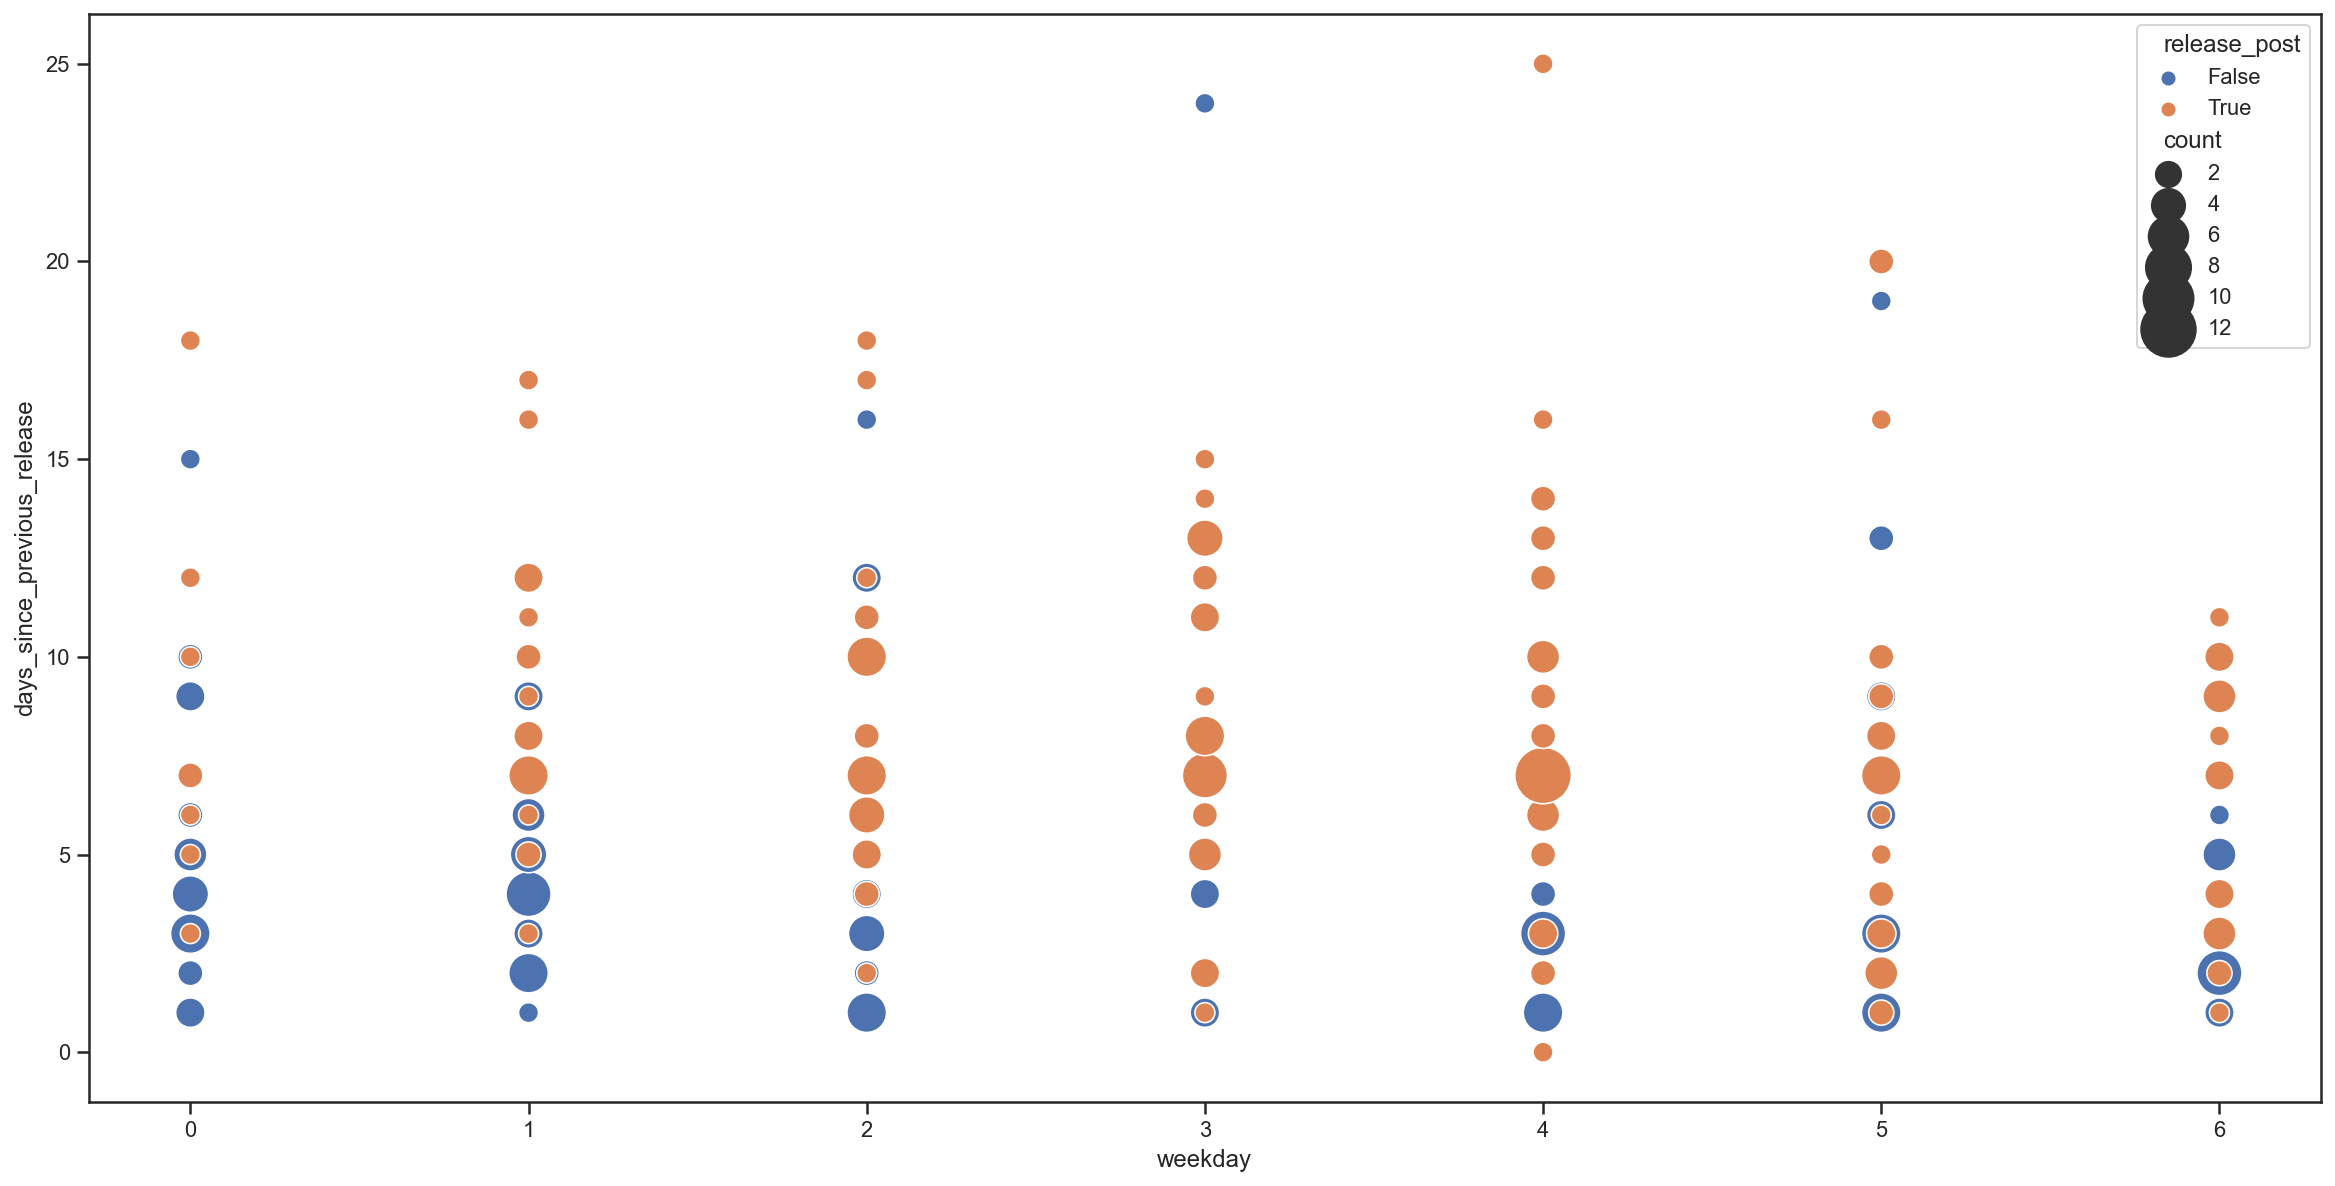

In [11]:
temp = all_df.groupby(["release_post", "weekday", "days_since_previous_release"]).size().reset_index()
temp = temp.rename(columns={0 : "count"})
sns.scatterplot(data=temp, x="weekday", y="days_since_previous_release", hue="release_post",
                size="count", sizes=(100, 800))

---

In [16]:
train_df["release_prob"] = train_df["release_post"].apply(lambda x : 100 if x else 0)
test_df["release_prob"] = test_df["release_post"].apply(lambda x : 100 if x else 0)

In [53]:
classifier = LinearRegression()
classifier.fit(train_df[["days_since_previous_release", "weekday"]], train_df["release_prob"])
test_df["predicted_release_prob"] = classifier.predict(test_df[["days_since_previous_release", "weekday"]])

In [54]:
test_df[["release_prob", "predicted_release_prob"]].corr()

,release_prob,predicted_release_prob
release_prob,1.000000,0.365761
predicted_release_prob,0.365761,1.000000


<AxesSubplot:xlabel='predicted_release_prob', ylabel='Density'>

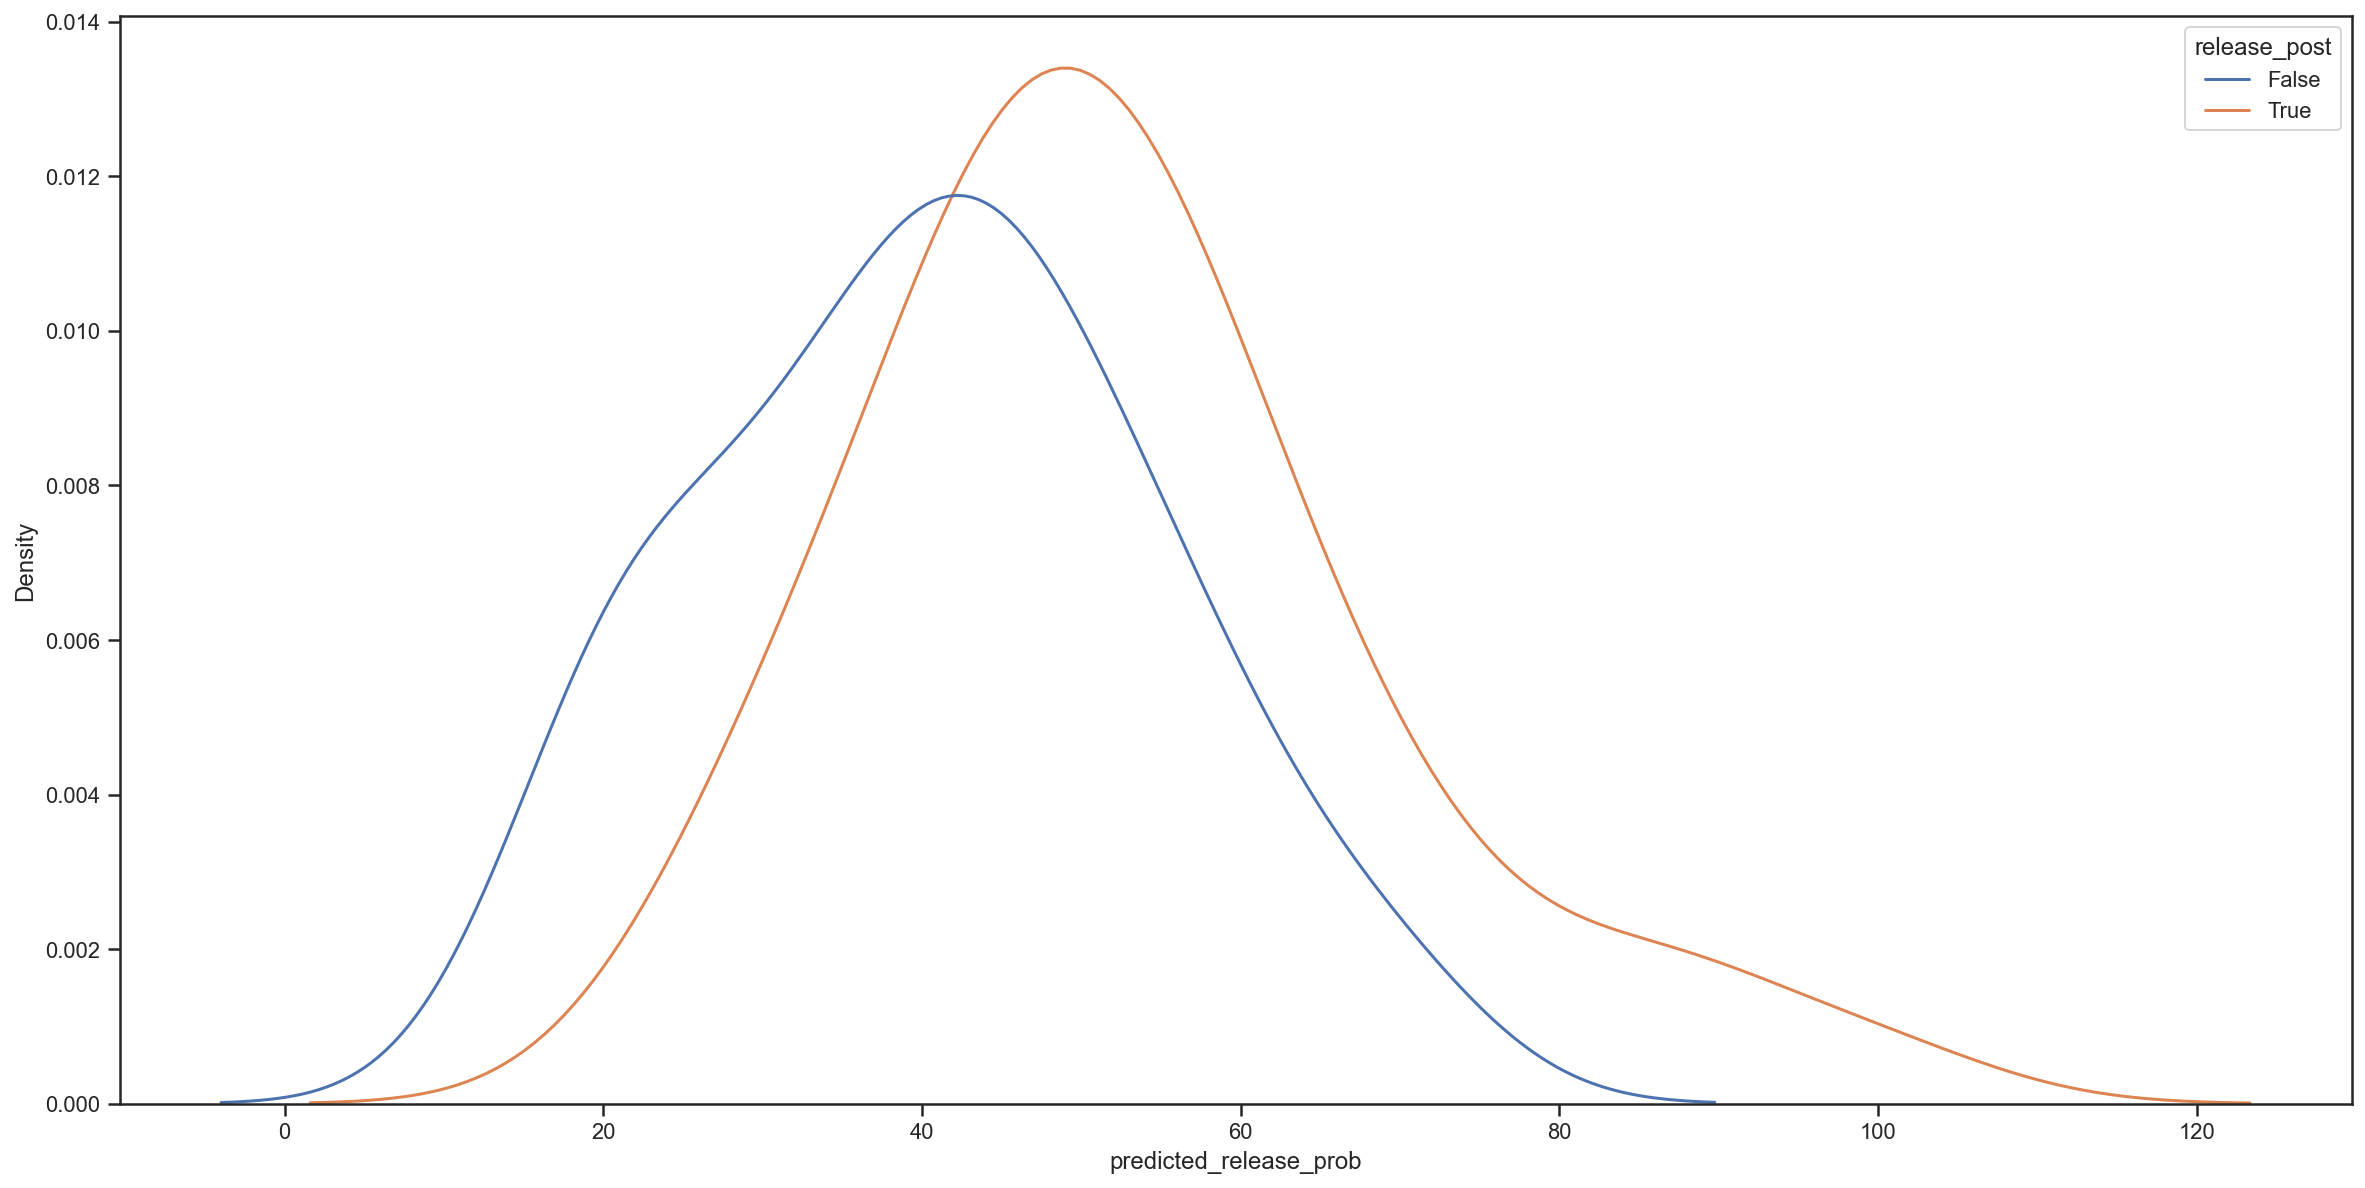

In [29]:
sns.kdeplot(data=test_df, x="predicted_release_prob", hue="release_post")

<AxesSubplot:xlabel='predicted_release_prob', ylabel='Count'>

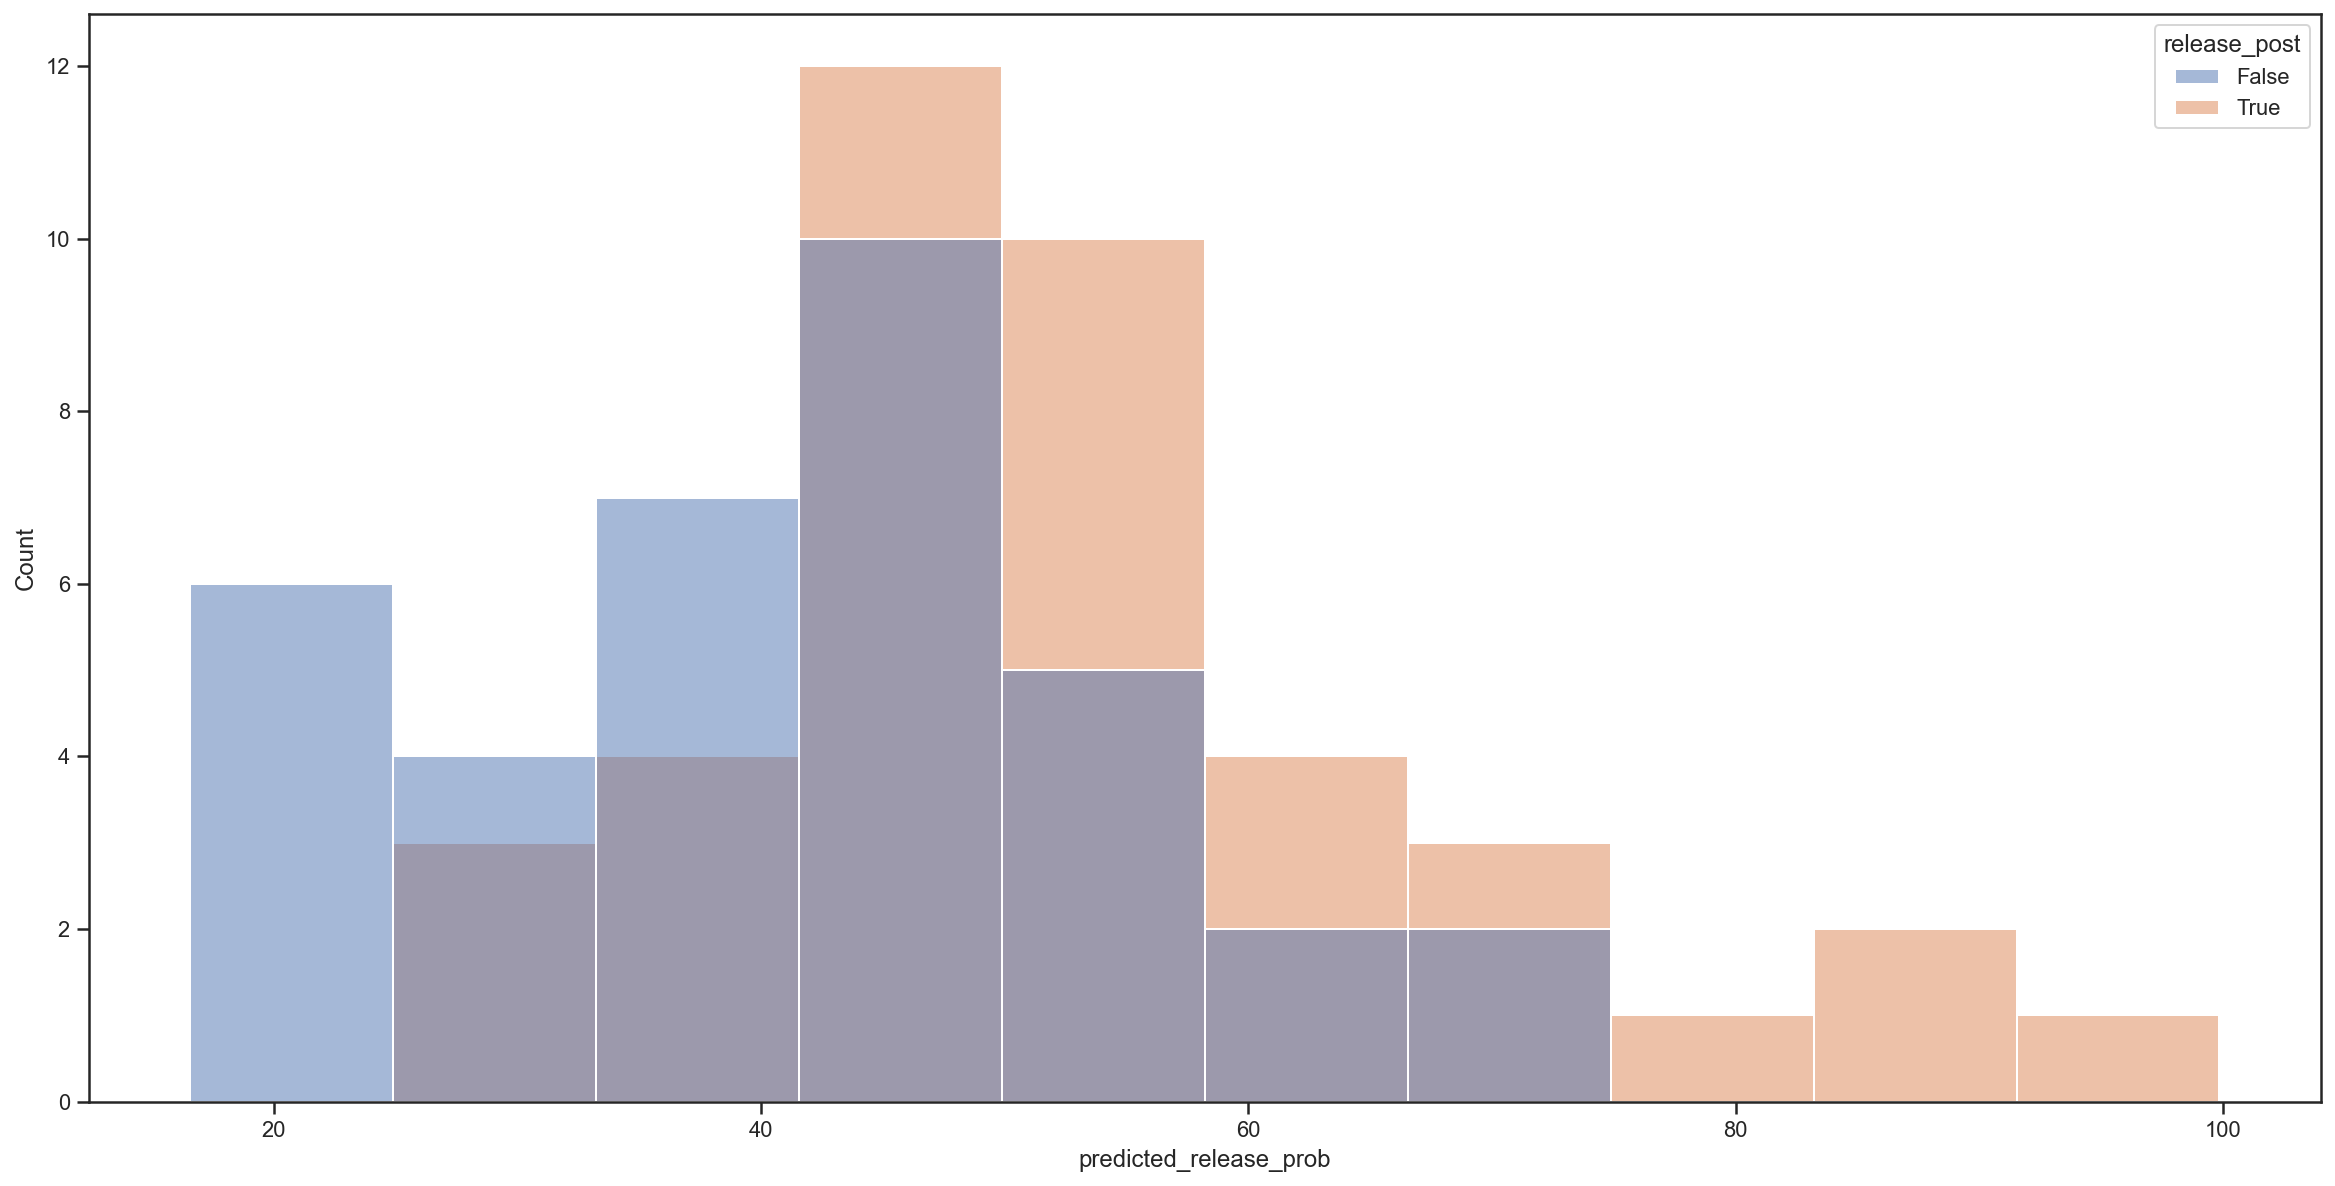

In [30]:
sns.histplot(data=test_df, x="predicted_release_prob", hue="release_post")

In [44]:
threshold = 45

In [45]:
tp = len(test_df.query('release_prob == 100 & predicted_release_prob >= {}'.format(threshold)))
fp = len(test_df.query('release_prob == 0 & predicted_release_prob >= {}'.format(threshold)))
fn = len(test_df.query('release_prob == 100 & predicted_release_prob < {}'.format(threshold)))

print(tp / (tp + fp))
print(tp / (tp + fn))

0.65
0.65


---

In [32]:
days_since_most_recent_release = (datetime.now() - df.iloc[-1]["date"]).days

In [55]:
next_30_days = [(datetime.now() + timedelta(days=i), i + days_since_most_recent_release, 
                 (datetime.now() + timedelta(days=i)).weekday()) for i in range(1, 31)]
future_df = pandas.DataFrame(next_30_days, columns=["date", "days_since_previous_release", "weekday"])
future_df["predicted_release_prob"] = classifier.predict([f[1:] for f in next_30_days])
future_df["release_probability"] = future_df["predicted_release_prob"].apply(
    lambda x : True if x >= threshold else False)

future_df

,date,days_since_previous_release,weekday,predicted_release_prob,release_probability
0,2021-03-11 20:56:56.794342,7,3,51.491901,True
1,2021-03-12 20:56:56.794358,8,4,60.183212,True
2,2021-03-13 20:56:56.794362,9,5,68.874524,True
3,2021-03-14 20:56:56.794365,10,6,77.565835,True
4,2021-03-15 20:56:56.794368,11,0,56.412008,True
5,2021-03-16 20:56:56.794372,12,1,65.103319,True
6,2021-03-17 20:56:56.794375,13,2,73.794630,True
7,2021-03-18 20:56:56.794378,14,3,82.485942,True
8,2021-03-19 20:56:56.794381,15,4,91.177253,True
9,2021-03-20 20:56:56.794384,16,5,99.868564,True
